0803 실습완

* XGBoost 버전 확인

In [ ]:
#conda install -c anaconda py-xgboost

In [1]:
import xgboost

print(xgboost.__version__)

0.90


### 파이썬 Native XGBoost 적용 – 위스콘신 Breast Cancer 데이터 셋

**데이터 세트 로딩 하기**

In [2]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
# xgboost 패키지 로딩하기
import xgboost as xgb
from xgboost import plot_importance

import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features= dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target']= labels
cancer_df.head(3)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.8,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.6,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.9,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.8,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.0,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.5,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0


In [3]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [4]:
# cancer_df에서 feature용 DataFrame과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label이므로 Feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 컬럼까지를 :-1 슬라이싱으로 추출.
X_features = cancer_df.iloc[:, :-1]
y_label = cancer_df.iloc[:, -1]

# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test=train_test_split(X_features, y_label, test_size=0.2, random_state=156 )

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리 
X_tr, X_val, y_tr, y_val= train_test_split(X_train, y_train, test_size=0.1, random_state=156 )

print(X_train.shape , X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


**학습과 예측 데이터 세트를 DMatrix로 변환**
* DMatrix는 넘파이 array, DataFrame에서도 변환 가능

In [5]:
# 만약 구버전 XGBoost에서 DataFrame으로 DMatrix 생성이 안될 경우 X_train.values로 넘파이 변환. 
# 학습, 검증, 테스트용 DMatrix를 생성. 
dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test , label=y_test)

**하이퍼 파라미터 설정**

In [6]:
params = { 'max_depth':3,
           'eta': 0.05,
           'objective':'binary:logistic',
           'eval_metric':'logloss'
        }
num_rounds = 400

**주어진 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달하고 학습**

In [7]:
# 학습 데이터 셋은 'train' 또는 평가 데이터 셋은 'eval' 로 명기합니다. 
eval_list = [(dtr,'train'),(dval,'eval')] # 또는 eval_list = [(dval,'eval')] 만 명기해도 무방. 

# 하이퍼 파라미터와 early stopping 파라미터를 train( ) 함수의 파라미터로 전달
xgb_model = xgb.train(params = params , dtrain=dtr , num_boost_round=num_rounds , \
                      early_stopping_rounds=50, evals=eval_list )

[0]	train-logloss:0.650163	eval-logloss:0.661831
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[1]	train-logloss:0.611313	eval-logloss:0.636086
[2]	train-logloss:0.575629	eval-logloss:0.611436
[3]	train-logloss:0.543102	eval-logloss:0.592036
[4]	train-logloss:0.513233	eval-logloss:0.573291
[5]	train-logloss:0.484475	eval-logloss:0.550371
[6]	train-logloss:0.457959	eval-logloss:0.529295
[7]	train-logloss:0.434357	eval-logloss:0.51534
[8]	train-logloss:0.411503	eval-logloss:0.497179
[9]	train-logloss:0.390274	eval-logloss:0.481542
[10]	train-logloss:0.371284	eval-logloss:0.469904
[11]	train-logloss:0.352541	eval-logloss:0.45474
[12]	train-logloss:0.335277	eval-logloss:0.442294
[13]	train-logloss:0.318925	eval-logloss:0.429608
[14]	train-logloss:0.304394	eval-logloss:0.42065
[15]	train-logloss:0.289996	eval-logloss:0.409577
[16]	train-logloss:0.276514	eval-logloss:0.398867
[17]	train-log

**predict()를 통해 예측 확률값을 반환하고 예측 값으로 변환**

In [8]:
pred_probs = xgb_model.predict(dtest)
print('predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨')
print(np.round(pred_probs[:10],3))

# 예측 확률이 0.5 보다 크면 1 , 그렇지 않으면 0 으로 예측값 결정하여 List 객체인 preds에 저장 
preds = [ 1 if x > 0.5 else 0 for x in pred_probs ]
print('예측값 10개만 표시:',preds[:10])

predict( ) 수행 결과값을 10개만 표시, 예측 확률 값으로 표시됨
[0.845 0.008 0.68  0.081 0.975 0.999 0.998 0.998 0.996 0.001]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [9]:
pred_probs

array([0.8447872 , 0.00842587, 0.6796298 , 0.08113331, 0.9751338 ,
       0.9988939 , 0.9983084 , 0.9980654 , 0.99637896, 0.00138468,
       0.00252283, 0.00154995, 0.99780875, 0.99829525, 0.99691856,
       0.9965521 , 0.99120796, 0.9982718 , 0.9970682 , 0.9978916 ,
       0.00202923, 0.10774372, 0.00137198, 0.9989255 , 0.00107862,
       0.7800014 , 0.00295459, 0.00154995, 0.9966723 , 0.05379276,
       0.958738  , 0.00149019, 0.9700533 , 0.8656249 , 0.00678389,
       0.00140975, 0.97810876, 0.99713576, 0.24059245, 0.9972307 ,
       0.35760084, 0.99708337, 0.9919429 , 0.99659145, 0.9962838 ,
       0.9179466 , 0.036952  , 0.997417  , 0.99325067, 0.99804085,
       0.99648905, 0.00236221, 0.9979361 , 0.99784875, 0.9960328 ,
       0.99391055, 0.9984106 , 0.99635327, 0.9967404 , 0.896291  ,
       0.9967794 , 0.9520696 , 0.00349248, 0.00202715, 0.9980167 ,
       0.98225844, 0.00349248, 0.99056447, 0.9972249 , 0.9978916 ,
       0.00297725, 0.99731344, 0.00163038, 0.98887384, 0.99624

**get_clf_eval( )을 통해 예측 평가**

In [10]:
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))

In [11]:
get_clf_eval(y_test , preds, pred_probs)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9937


**Feature Importance 시각화**

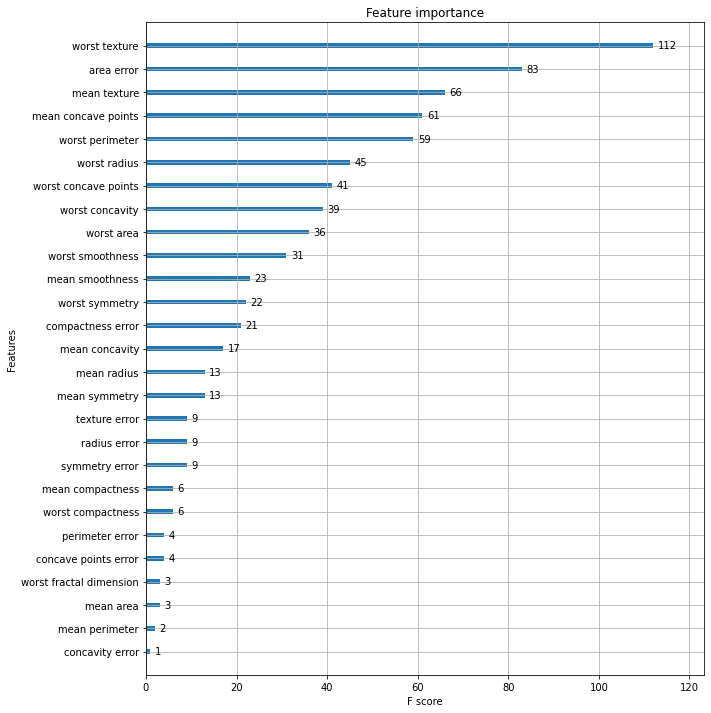

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
plot_importance(xgb_model, ax=ax)

### 사이킷런 Wrapper XGBoost 개요 및 적용 

**사이킷런 래퍼 클래스 임포트, 학습 및 예측**

In [13]:
# 사이킷런 래퍼 XGBoost 클래스인 XGBClassifier 임포트
from xgboost import XGBClassifier

# Warning 메시지를 없애기 위해 eval_metric 값을 XGBClassifier 생성 인자로 입력. 미 입력해도 수행에 문제 없음.   
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3, eval_metric='logloss')
xgb_wrapper.fit(X_train, y_train, verbose=True)
w_preds = xgb_wrapper.predict(X_test)
w_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

In [16]:
get_clf_eval(y_test , w_preds, w_pred_proba)

오차 행렬
[[34  3]
 [ 1 76]]
정확도: 0.9649, 정밀도: 0.9620, 재현율: 0.9870,    F1: 0.9744, AUC:0.9954


**early stopping을 50으로 설정하고 재 학습/예측/평가**

In [17]:
from xgboost import XGBClassifier

# 왜 loss가 두개지, 아 train이랑 validation 같이 했네
xgb_wrapper = XGBClassifier(n_estimators=400, learning_rate=0.05, max_depth=3)
evals = [(X_tr, y_tr), (X_val, y_val)]
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=50, eval_metric="logloss", 
                eval_set=evals, verbose=True)

ws50_preds = xgb_wrapper.predict(X_test)
ws50_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]

[0]	validation_0-logloss:0.650162	validation_1-logloss:0.661831
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 50 rounds.
[1]	validation_0-logloss:0.611314	validation_1-logloss:0.636086
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.611436
[3]	validation_0-logloss:0.543099	validation_1-logloss:0.592036
[4]	validation_0-logloss:0.513234	validation_1-logloss:0.573291
[5]	validation_0-logloss:0.484475	validation_1-logloss:0.550371
[6]	validation_0-logloss:0.457959	validation_1-logloss:0.529295
[7]	validation_0-logloss:0.434357	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.411503	validation_1-logloss:0.497179
[9]	validation_0-logloss:0.390274	validation_1-logloss:0.481542
[10]	validation_0-logloss:0.371284	validation_1-logloss:0.469904
[11]	validation_0-logloss:0.352541	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.335278	validation_1-logloss:0.442294
[13

In [15]:
get_clf_eval(y_test , ws50_preds, ws50_pred_proba)

오차 행렬
[[34  3]
 [ 2 75]]
정확도: 0.9561, 정밀도: 0.9615, 재현율: 0.9740,    F1: 0.9677, AUC:0.9933


**early stopping을 10으로 설정하고 재 학습/예측/평가**

In [18]:
# early_stopping_rounds를 10으로 설정하고 재 학습. 
xgb_wrapper.fit(X_tr, y_tr, early_stopping_rounds=10, 
                eval_metric="logloss", eval_set=evals,verbose=True)

ws10_preds = xgb_wrapper.predict(X_test)
ws10_pred_proba = xgb_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test , ws10_preds, ws10_pred_proba)

[0]	validation_0-logloss:0.650162	validation_1-logloss:0.661831
Multiple eval metrics have been passed: 'validation_1-logloss' will be used for early stopping.

Will train until validation_1-logloss hasn't improved in 10 rounds.
[1]	validation_0-logloss:0.611314	validation_1-logloss:0.636086
[2]	validation_0-logloss:0.57563	validation_1-logloss:0.611436
[3]	validation_0-logloss:0.543099	validation_1-logloss:0.592036
[4]	validation_0-logloss:0.513234	validation_1-logloss:0.573291
[5]	validation_0-logloss:0.484475	validation_1-logloss:0.550371
[6]	validation_0-logloss:0.457959	validation_1-logloss:0.529295
[7]	validation_0-logloss:0.434357	validation_1-logloss:0.51534
[8]	validation_0-logloss:0.411503	validation_1-logloss:0.497179
[9]	validation_0-logloss:0.390274	validation_1-logloss:0.481542
[10]	validation_0-logloss:0.371284	validation_1-logloss:0.469904
[11]	validation_0-logloss:0.352541	validation_1-logloss:0.45474
[12]	validation_0-logloss:0.335278	validation_1-logloss:0.442294
[13

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

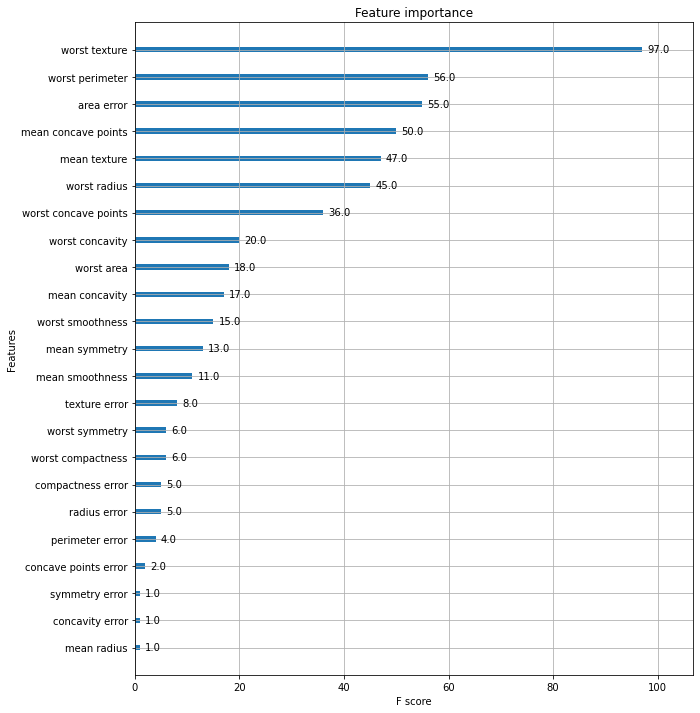

In [ ]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(10, 12))
# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(xgb_wrapper, ax=ax)